In [2]:
import pandas as pd
import numpy as np

## step 1. Crawling comments from Youtube url

    - input: specific Youtube url 

    - output: dataframe (id, comments, likes)

* reference: [Selenium을 이용해 Youtube 댓글 가져오기](https://somjang.tistory.com/entry/PythonSelenium%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9C%A0%ED%8A%9C%EB%B8%8C-%EB%8C%93%EA%B8%80-%EA%B0%80%EC%A0%B8%EC%98%A4%EA%B8%B0

    - 기존 [Youtube-Comment-Crawler](https://github.com/SOMJANG/Youtube_Comment_Crawler) 보완
        - Mac에서 돌아가지 않았음
        - 좋아요 개수 수집하지 못했음

In [2]:
! pip install selenium

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [6]:
! brew install chromedriver

/bin/sh: brew: command not found


In [7]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
import time
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

In [8]:
# for test new webdriver
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # chromedriver 설치 후, /usr/local/bin/으로 옮겨줘야 함 
driver.get('http://www.google.com/xhtml');
time.sleep(5)

search_box = driver.find_element_by_name('q')
search_box.send_keys('ChromeDriver')
search_box.submit()
time.sleep(5)

driver.quit()

In [9]:
def crawl_youtube_page_html_sources(url):
    html_sources = []

    for i in range(5):
        driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # chromedriver 설치 후, /usr/local/bin/으로 옮겨줘야 함 
        driver.get(url)
        time.sleep(5)
        last_page_height = driver.execute_script("return document.body.scrollHeight")
        # last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        while True:
            time.sleep(5)
            #driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight-50);")
            time.sleep(5)
            #new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
            new_page_height = driver.execute_script("return document.body.scrollHeight")
            if new_page_height == last_page_height:
                break
            last_page_height = new_page_height


        html_source = driver.page_source
        html_sources.append(html_source)

        driver.quit()
    return html_sources

In [56]:
def get_user_IDs_and_comments(html_sources):
    my_dataframes = []
    for html in html_sources:
        
        soup = BeautifulSoup(html, 'lxml')
        total_comments = soup.find("yt-formatted-string", class_ ="count-text style-scope ytd-comments-header-renderer").text
        print('총', end = '')
        print(total_comments)
        youtube_user_IDs = soup.select('div#header-author > a > span')
        youtube_comments = soup.select('yt-formatted-string#content-text') ##content-text > span:nth-child(1) 
        youtube_likes = soup.select('div#toolbar > span#vote-count-middle')

        str_youtube_userIDs = []
        str_youtube_comments = []
        str_youtube_likes = []

        for i in range(len(youtube_user_IDs)):
            # user id 
            str_tmp = str(youtube_user_IDs[i].text)
            str_tmp = str_tmp.replace('\n', ' ')
            str_tmp = str_tmp.replace('\t', ' ')
            str_tmp = str_tmp.replace('                ',' ')
            str_youtube_userIDs.append(str_tmp)
            # comments
            str_tmp = str(youtube_comments[i].text) 
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', ' ')
            str_youtube_comments.append(str_tmp)
            # likes
            str_tmp = str(youtube_likes[i].text)
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', '')
            str_youtube_likes.append(str_tmp)
            
        pd_data = {"ID":str_youtube_userIDs, "Comment":str_youtube_comments, "Like": str_youtube_likes }
        youtube_pd = pd.DataFrame(pd_data)
        my_dataframes.append(youtube_pd)
        
    return my_dataframes

In [57]:
def crawling_url(url):
    html_sorces = crawl_youtube_page_html_sources(urls)
    my_df = get_user_IDs_and_comments(html_sorces)
    df = my_df[0]
    for i in range(1,len(my_df)):
        df = pd.concat([df, my_df[i]])
    df = df.drop_duplicates()        
    return df 

In [104]:
urls = 'https://www.youtube.com/watch?v=ioNng23DkIM'
cmts = crawling_url(urls) # comments output after crawling

총댓글 3,112,445개
총댓글 3,112,448개
총댓글 3,112,449개
총댓글 3,112,451개
총댓글 3,112,492개


In [105]:
cmts

,ID,Comment,Like
0,Ly Ly,"Everyday we're getting closer to 700M, but the...",2.5천
1,Anh Lan,Lisa,9.5천
2,Fresrit Gaming,Jisooo,4.9만
3,Wss 16,Jisoo,5.3만
4,b o i,"I swear Lisa is such a bias wrecker,her rap tho-",9.3천
...,...,...,...
35,yashwanth kommasani,This comment section is getting worse,1.6만
66,毛毛,80M in 24h we did it blinksss,4천
83,Irene Dominguez,Vote MAMA BLACKPINK HOU YOU LIKE THAT Best son...,301
86,4 years with JenChuLiChaeng ...,Blinks don't forget to vote on mama soty and h...,465


In [107]:
# change str to num
likes = list(cmts['Like'])
for i in range(len(likes)):
    likes[i] = likes[i].replace(' ','')
    if likes[i][-1] == '천': 
        likes[i] = float(likes[i][:-1])*1000
    elif likes[i][-1] == '만': 
        likes[i] = float(likes[i][:-1])*10000
    else: likes[i] = float(likes[i])
cmts['Like'] = likes

In [113]:
cmts = cmts[['ID', 'Like', 'Comment']]

In [114]:
cmts.to_csv('comments_eng2.csv', index = False)

In [116]:
comments = list(cmts['Comment'])

## Step 2) preprocess 

    - input) comments list
    - output) comments list

- 이모티콘, 문장부호, 줄바꿈 제거 
- 띄어쓰기 제거 
- 문법 오류 교정 (optional)

In [4]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import re
text = '🏡 Hi my name is midan ~~ 😆🌹'

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(emoji_pattern.sub(r'', text)) # no emoji

 Hi my name is midan ~~ 


In [5]:
# https://jdh5202.tistory.com/394
import re
def cleanText(readData):
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    return text
 
print(cleanText('Hi there~!~! holly~~ $%^&#*'))

Hi there holly 


In [13]:
!pip install chatspace

In [117]:
## 이모티콘, 문장부호, 이모지 제거 
after_cleansing = []
for i in range(5):
    print(comments[i])
    temp = cleanText(comments[i]) # 문장부호 제거 
    print(temp)
    temp = emoji_pattern.sub(r'', temp) # 이모지 제거 
    print(temp)
    after_cleansing.append(temp)
    print()

Everyday we're getting closer to 700M, but the gap is also getting smaller.. BLINKS stre4m harder!!!
Everyday were getting closer to 700M but the gap is also getting smaller BLINKS stre4m harder
Everyday were getting closer to 700M but the gap is also getting smaller BLINKS stre4m harder

Lisa
Lisa
Lisa

Jisooo
Jisooo
Jisooo

Jisoo
Jisoo
Jisoo

I swear Lisa is such a bias wrecker,her rap tho-
I swear Lisa is such a bias wreckerher rap tho
I swear Lisa is such a bias wreckerher rap tho



In [66]:
def preprocess(comment):
    comment = cleanText(comment) # 문장부호 제거 
    comment = emoji_pattern.sub(r'', comment) # 이모지 제거 
    return comment

In [123]:
after_cleansing = []
for i in range(len(comments)):
    after_cleansing.append(preprocess(comments[i]))

In [119]:
after_cleansing[:20]

['Everyday were getting closer to 700M but the gap is also getting smaller BLINKS stre4m harder',
 'Lisa',
 'Jisooo',
 'Jisoo',
 'I swear Lisa is such a bias wreckerher rap tho',
 'Everyday were getting closer to 700M but the gap is also getting smaller BLINKS stre4m harder',
 'Lisa',
 'Jisooo',
 'Jisoo',
 'I swear Lisa is such a bias wreckerher rap tho',
 'Vote for BLACKPINK MAMA SOTY',
 'Lisa FIREJennie FABRose FIERCEJisoo FANCY',
 'ROSÉ I LOVE YOU',
 'If youre a hater go away We are all looking for love and positivity',
 'LisaJennie Look at you now look at meme insecurities have entered the chat',
 'VOTE FOR BLACKPINK MAMA SOTY',
 'Jisoooo',
 'KIM JISOOKIM JENNIEPARK CHAEYOUNGLALISAWE LOVE YOU',
 'Jisoo voice',
 'Rose proved she’s the main vocal 028041']

In [131]:
cmts['cleansing_comments'] = after_cleansing
cmts

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,Like,Comment,cleansing_comments
0,Ly Ly,2500.0,"Everyday we're getting closer to 700M, but the...",Everyday were getting closer to 700M but the g...
1,Anh Lan,9500.0,Lisa,Lisa
2,Fresrit Gaming,49000.0,Jisooo,Jisooo
3,Wss 16,53000.0,Jisoo,Jisoo
4,b o i,9300.0,"I swear Lisa is such a bias wrecker,her rap tho-",I swear Lisa is such a bias wreckerher rap tho
...,...,...,...,...
35,yashwanth kommasani,16000.0,This comment section is getting worse,This comment section is getting worse
66,毛毛,4000.0,80M in 24h we did it blinksss,80M in 24h we did it blinksss
83,Irene Dominguez,301.0,Vote MAMA BLACKPINK HOU YOU LIKE THAT Best son...,Vote MAMA BLACKPINK HOU YOU LIKE THAT Best son...
86,4 years with JenChuLiChaeng ...,465.0,Blinks don't forget to vote on mama soty and h...,Blinks dont forget to vote on mama soty and hy...


In [132]:
cmts.index = range(0, len(cmts))

In [133]:
cmts

,ID,Like,Comment,cleansing_comments
0,Ly Ly,2500.0,"Everyday we're getting closer to 700M, but the...",Everyday were getting closer to 700M but the g...
1,Anh Lan,9500.0,Lisa,Lisa
2,Fresrit Gaming,49000.0,Jisooo,Jisooo
3,Wss 16,53000.0,Jisoo,Jisoo
4,b o i,9300.0,"I swear Lisa is such a bias wrecker,her rap tho-",I swear Lisa is such a bias wreckerher rap tho
...,...,...,...,...
208,yashwanth kommasani,16000.0,This comment section is getting worse,This comment section is getting worse
209,毛毛,4000.0,80M in 24h we did it blinksss,80M in 24h we did it blinksss
210,Irene Dominguez,301.0,Vote MAMA BLACKPINK HOU YOU LIKE THAT Best son...,Vote MAMA BLACKPINK HOU YOU LIKE THAT Best son...
211,4 years with JenChuLiChaeng ...,465.0,Blinks don't forget to vote on mama soty and h...,Blinks dont forget to vote on mama soty and hy...


## Step 3) Analysis

    - input: dataframe (id, comments, likes)
    - output: specific outputs of each analysis

- Word Cloud
- 10 most liked comments
- sentimental analysis

In [30]:
# Word Cloud
!pip install wordcloud

     |████████████████████████████████| 220 kB 1.5 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158511 sha256=bde446f631c395e312ce1a381782857ab84f9a8f0bb5452aa9affdfc3d119dd2
  Stored in directory: /Users/midan/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud


In [140]:
all_comments = ''
for comment in list(cmts['cleansing_comments']):
    all_comments+= comment + " "

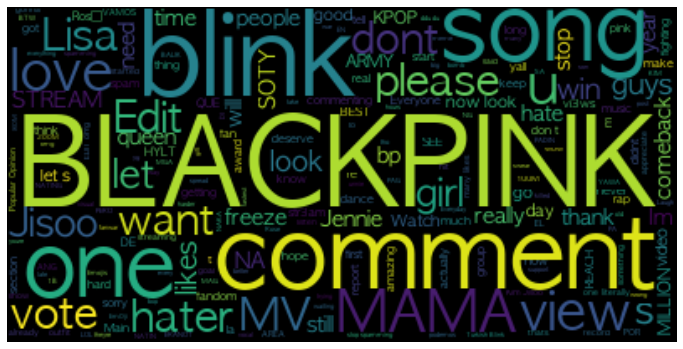

In [141]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(all_comments)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [136]:
# 10 most liked comments
like10 = cmts.sort_values(by=['Like'], ascending=False)
like10.index = range(0, len(like10))
like10.head(10)

,ID,Like,Comment,cleansing_comments
0,maengay mercadejas,120000.0,"I really like this song, BLACKPINK didn't disa...",I really like this song BLACKPINK didnt disapp...
1,Haechannie,100000.0,We have to drown the annoying “no one:” jokes ...,We have to drown the annoying “no one” jokes w...
2,I’m Muffin,81000.0,Haters: no one literally no one blahblahblah C...,Haters no one literally no one blahblahblah Co...
3,Meriah,80000.0,I hate that people are fighting over this... I...,I hate that people are fighting over this I’m ...
4,MOTIVATIONAL VIDEOS,75000.0,How many international fans are here? 🌍,How many international fans are here
5,elsa cazenave,73000.0,2016= Boombayah2017= As If Its Your Last 2018...,2016 Boombayah2017 As If Its Your Last 2018 ...
6,Rifki Dhio,67000.0,NOT JISOO ERANOT JENNIE ERANOT ROSÉ ERANOT LIS...,NOT JISOO ERANOT JENNIE ERANOT ROSÉ ERANOT LIS...
7,ONLY AR,64000.0,BLACKPINK - ‘How You Like That’ has been certi...,BLACKPINK How You Like That’ has been certifi...
8,Δήμητρα Βλαχονικόλα,63000.0,"The outfits, the visuals, the hairstyles, the ...",The outfits the visuals the hairstyles the cho...
9,yacine sg,59000.0,ROSÉ I LOVE YOU,ROSÉ I LOVE YOU


In [142]:
# 좋아요 개수 20개 이상의 댓글들로만 word cloud 

like20_comments = ''
for comment in list(like10['cleansing_comments'].loc[:19]):
    like20_comments+= comment + " "

In [143]:
like10[['Comment', 'Like']].loc[:19]

,Comment,Like
0,"I really like this song, BLACKPINK didn't disa...",120000.0
1,We have to drown the annoying “no one:” jokes ...,100000.0
2,Haters: no one literally no one blahblahblah C...,81000.0
3,I hate that people are fighting over this... I...,80000.0
4,How many international fans are here? 🌍,75000.0
5,2016= Boombayah2017= As If Its Your Last 2018...,73000.0
6,NOT JISOO ERANOT JENNIE ERANOT ROSÉ ERANOT LIS...,67000.0
7,BLACKPINK - ‘How You Like That’ has been certi...,64000.0
8,"The outfits, the visuals, the hairstyles, the ...",63000.0
9,ROSÉ I LOVE YOU,59000.0


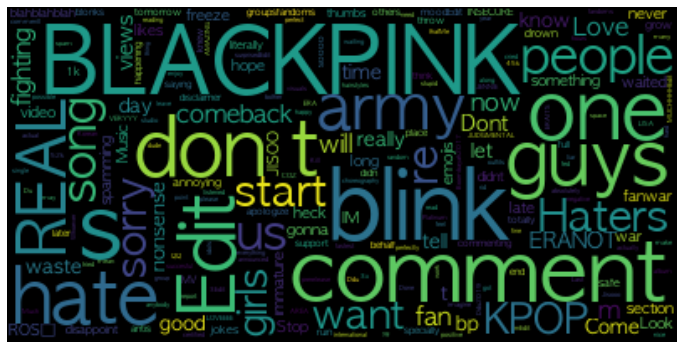

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image
 
cloud_mask = np.array(Image.open("cloud.png"))

wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(like20_comments)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

### sentimental analysis 
-  with [Vader](https://github.com/cjhutto/vaderSentiment)
    - VADER가 sns 에서의 감정분석에 더욱 특화되어 있기 때문



In [146]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 1.9 MB/s eta 0:00:01


In [147]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [148]:
# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co

In [153]:
neg = []
neu = []
pos = []
compound = []

analyzer = SentimentIntensityAnalyzer()
for temp in after_cleansing:
    vs = analyzer.polarity_scores(temp)
    neg.append(vs['neg'])
    pos.append(vs['pos'])
    neu.append(vs['neu'])
    compound.append(vs['compound'])

In [155]:
senti = pd.DataFrame( {
    'negative': neg, 'neutral': neu, 'positive':pos, 'compound':compound
} )

In [156]:
senti

,negative,neutral,positive,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.245,0.755,0.000,-0.1531
...,...,...,...,...
208,0.383,0.617,0.000,-0.4767
209,0.000,1.000,0.000,0.0000
210,0.000,0.548,0.452,0.8143
211,0.000,0.878,0.122,0.1695


In [169]:
print('aver neg:\t' + str(sum(neg)/float(len(neg))))
print('aver neu:\t' + str(sum(neu)/float(len(neg))))
print('aver pos:\t' + str(sum(pos)/float(len(neg))))
print('aver compound:\t' + str(sum(compound)/float(len(neg))))  

aver neg:	0.06112676056338028
aver neu:	0.7864413145539906
aver pos:	0.15242253521126758
aver compound:	0.1956474178403756


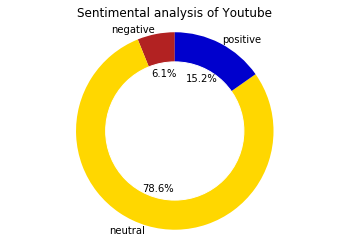

In [182]:
# visualization
my_circle = plt.Circle((0, 0), 0.7, color='white')
labels = ['negative', 'neutral', 'positive']
sentis = [sum(neg)/float(len(neg)), sum(neu)/float(len(neu)), sum(pos)/float(len(pos))]
d = plt.pie(sentis, labels=labels, autopct='%1.1f%%',
            startangle=90, labeldistance=1.05, colors = ['firebrick', 'gold', 'mediumblue'])
plt.axis('equal')
plt.gca().add_artist(my_circle)
plt.title('Sentimental analysis of Youtube')            
plt.show()

In [180]:
# visualization
def my_plot(title_name, data_list):
    #plt.hist(data_list, range=(0,1), bins=25)
    plt.title(title_name)
    plt.xlabel('<--     negative            [scores]             positive     -->')
    plt.ylabel('count')
    # Plot histogram.
    cm = plt.cm.get_cmap('RdYlBu_r')
    n, bins, patches = plt.hist(data_list, 25, normed=1, color='green', alpha = 0.8, edgecolor = 'black', linewidth = 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


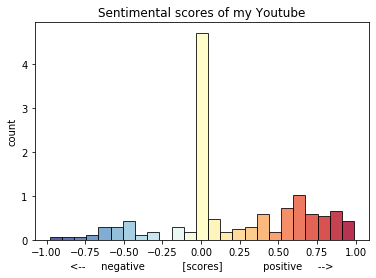

In [181]:
my_plot('Sentimental scores of my Youtube', compound)